In [1]:
import scipy         
import datetime
from scipy.linalg import expm,det
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit
from scipy.integrate import solve_ivp,odeint
from functools import reduce


In [2]:
L = 3 #system size
l=1 #spin length
M = 0.1
m_epsilon = 0
N=3
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [3]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
      0.         |2 2 2>           26  
      1.         |2 2 1>           25  
      2.         |2 2 0>           24  
      3.         |2 1 2>           23  
      4.         |2 1 1>           22  
      5.         |2 1 0>           21  
      6.         |2 0 2>           20  
      7.         |2 0 1>           19  
      8.         |2 0 0>           18  
      9.         |1 2 2>           17  
     10.         |1 2 1>           16  
     11.         |1 2 0>           15  
     12.         |1 1 2>           14  
     13.         |1 1 1>           13  
     14.         |1 1 0>           12  
     15.         |1 0 2>           11  
     16.         |1 0 1>           10  
     17.         |1 0 0>            9  
     18.         |0 2 2>            8  
     19.         |0 2 1>            7  
     20.         |0 2 0>            6  
     21.         |0 1 2>            5  
     22.         |0 1 1>            4  
     23.   

In [4]:
#initialisation of the Gauss laws

liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []
z_comp_minf = [[-m_epsilon,0]]
z_comp_pinf = [[m_epsilon,L-1]]

for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    if i == 0:
        gauss_law_map.append([
            ["z",liste[0]],
            ["I",z_comp_minf],

        ])
    
    elif (i == L) & (i%2 == 0):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",z_comp_pinf],
        ])
    
    elif (i == L) & (i%2 == 1):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",liste[i-1]],
            ["I",z_comp_pinf],

        ])        
        
    elif i%2 == 0:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],
        ])
    elif i%2 == 1:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],  
            ["I",liste[i]]
        ])
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(L+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [5]:
B = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(int(4*l)+1)
b[int(2*l)+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.        ]
[0. 0. 0. 1. 0.]


In [6]:
C = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(int(4*l)+1)
c[int(2*l)] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [7]:
#projectors on g=1 for every site
Proj = [sparse.csr_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [8]:
A = np.zeros((int(2*l)+1,int(2*l)+1), dtype = complex)
for i in range(int(2*l)+1):
    for j in range(int(2*l)+1):
        A[i][j] = (-l+i)**j
b = np.zeros(int(2*l)+1,dtype = complex)
for i in range(int(2*l)+1):
    b[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,b)
x = np.zeros(int(2*3/2)+1, dtype = complex)
for i in range(int(2*l)+1):
    x[i] = solution[i]
print(x)
print(x.conj())

[ 1.+0.j  0.+0.j -2.-0.j  0.+0.j]
[ 1.-0.j  0.-0.j -2.+0.j  0.-0.j]


In [9]:
D = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(int(4*l)+1)
d[int(2*l)] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [10]:
E = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(int(4*l)+1)
e[int(2*l)-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.        ]
[0. 1. 0. 0. 0.]


In [11]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [12]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []

const_term_conj = []
linear_term_conj = []
quadratic_term_conj = []
cubic_term_conj = []

interaction_p = []
interaction_m = []

for i in range(L-1):
    const_term.append([[x[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term.append([[x[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term.append([[x[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term.append([[(x[3])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])

    const_term_conj.append([[x.conj()[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term_conj.append([[x.conj()[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term_conj.append([[x.conj()[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term_conj.append([[x.conj()[3]/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])


    interaction_p.append([
        ["+", const_term[i]],
        ["+z", linear_term[i]],
        ["+zz", quadratic_term[i]],
        ["+zzz", cubic_term[i]],


    ])

    interaction_m.append([
        ["-", const_term_conj[i]],
        ["-z", linear_term_conj[i]],
        ["-zz", quadratic_term_conj[i]],
        ["-zzz", cubic_term_conj[i]],


    ])
    
const_term.append([[(0.5*(-1)**m_epsilon)/np.sqrt(l*(l+1)),L-1]])
const_term_conj.append([[(0.5*np.conj((-1)**m_epsilon))/np.sqrt(l*(l+1)),L-1]])

interaction_p.append([
    ["+", const_term[L-1]]
])
interaction_m.append([
    ["-", const_term_conj[L-1]]
])

kin_energy = [[0.5,i,i] for i in range(L)]
mass_term = [[2*(-1)**i*M,i] for i in range(L)]

kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

H_int_p = []
H_int_m = []
interaction = [sparse.csr_matrix((basis.Ns,basis.Ns),dtype = complex) for i in range(L)]
h_int = sparse.csr_matrix((basis.Ns,basis.Ns))
for i in range(L):
    H_int_p.append(hamiltonian(interaction_p[i],dynamic_list=[],basis=basis,**no_checks))
    H_int_m.append(hamiltonian(interaction_m[i],dynamic_list=[],basis=basis,**no_checks))
    interaction[i] = (Proj[i]@H_int_p[i].tocsc()@Proj[i+1]+Proj[i+1]@H_int_m[i].tocsc()@Proj[i])

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_int #Spin-1 Hamiltonian without the local contstaints

for i in range(L+1):
    full_ham_matrix = (Proj[i]+Proj_0[i])@full_ham_matrix@(Proj[i]+Proj_0[i])
full_ham_matrix = 1.*full_ham_matrix

G=0
for i in range(L+1):
    G += 10*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= 1*(full_ham_matrix + constraint_full_matrix) #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [13]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")
print(eigenval[eigenval<=1e1])


[-0.64551385  0.42748942  0.7       ]


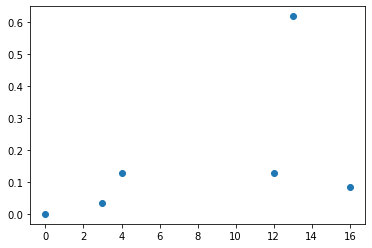

In [14]:
y = []
x = []
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])**2>=1e-4:
        y.append(np.abs(eigenvec[:,0][i])**2) 
        x.append(i)
plt.plot(x,y, "o")


In [15]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(1,int(L/2)):
        sigma_e = rot_sigma(2*k,i,j,phi,theta)@sigma_e
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)):
        sigma_o = rot_sigma(2*k+1,i,j,phi,theta)@sigma_o
    return(sigma_o)

def rot_sigma_r(i,j,phi,theta):
    sigma_r = sparse.identity(basis.Ns,dtype = complex)
    sigma_r = rot_sigma(0,i,j,phi,theta)@rot_sigma(L-1,i,j,phi,theta)
    return(sigma_r)


def sigma(k,i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    if k==0:
        tensprod = sigma
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,sigma)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def sigma_e(i,j,phi):
    sigma_e = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_e = sparse.csc_matrix(sigma_e)
    for k in range(1,int(L/2)):
        sigma_e +=sigma(2*k,i,j,phi)
    return sigma_e

def sigma_o(i,j,phi):
    sigma_o = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_o = sparse.csc_matrix(sigma_o)
    for k in range(int(L/2)):
        sigma_o +=sigma(2*k+1,i,j,phi)
    return sigma_o

def sigma_r(i,j,phi):
    sigma_r = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_r = sparse.csc_matrix(sigma_r)
    sigma_r = sigma(0,i,j,phi)+sigma(L-1,i,j,phi)
    return sigma_r

In [16]:

def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        summe +=tensprod
    return summe@summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()

    
def ms_hamiltonian_1(i,j,phi):
    sigma_p = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_m = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_z = np.zeros((2*l+1,2*l+1),dtype = complex)
    
    sigma_p[2*l-j][2*l-i] = 1.
    sigma_m[2*l-i][2*l-j] = 1.
    
    sigma_z[2*l-i][2*l-i] = 1.
    sigma_z[2*l-j][2*l-j] = -1.
    
    sigma_p = sparse.csc_matrix(sigma_p)
    sigma_m = sparse.csc_matrix(sigma_m)
    sigma_z = sparse.csc_matrix(sigma_z)

    sigma_big_p = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_m = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_z = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]

    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    
    for k in range(L):
        if k == 0:
            tensprod_p = sigma_p
            tensprod_m = sigma_m
            tensprod_z = sigma_z

            for m in range(L-1):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()
            tensprod_z = tensprod_z.toarray()
        else:
            tensprod_p = sparse.identity(2*l+1)
            tensprod_m = sparse.identity(2*l+1)
            tensprod_z = sparse.identity(2*l+1)
            
            for i in range(1,k):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = scipy.sparse.kron(tensprod_p,sigma_p)
            tensprod_m = scipy.sparse.kron(tensprod_m,sigma_m)
            tensprod_z = scipy.sparse.kron(tensprod_z,sigma_z)            
            for i in range(k+1,L):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()    
            tensprod_z = tensprod_z.toarray() 
            
        sigma_big_p[k] = tensprod_p
        sigma_big_m[k] = tensprod_m
        sigma_big_z[k] = tensprod_z

    for k in range(L):
        summe += 1.*sigma_big_z[k]
        for kk in range(k+1,L):
            summe += 1./np.abs(k-kk)**2*(sigma_big_p[k]@sigma_big_m[kk] + sigma_big_m[k]@sigma_big_p[kk])
    return summe
                
matrix_part_1 = ms_hamiltonian_1(1,2,0)
ms_ham_eigenval_1, ms_ham_eigenvec_1 = scipy.linalg.eigh(matrix_part_1)




def ms_gate_global_1(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval_1[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec_1@exponential@ms_ham_eigenvec_1.T.conj()

In [17]:
def swap(m,n):
    swap_matrix = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    swap_matrix = sparse.csc_matrix(swap_matrix)
    for i in range(basis.Ns):
        state_m = basis.int_to_state(basis.Ns-i-1)[2*m+1]
        state_n = basis.int_to_state(basis.Ns-i-1)[2*n+1]
        string = list(basis.int_to_state(basis.Ns-i-1))
        string[2*m+1],string[2*n+1] = state_n,state_m
        string = "".join(string)
        string = string.replace(" ", "")
        string = string.replace("|","")
        string = string.replace(">", "")
        i_new = basis.Ns-1-basis.state_to_int(string)
        swap_matrix[i_new,i] = 1.
        

    return swap_matrix


def exp_gate(k,theta):
    Matrix = np.zeros((9,9),dtype = complex)
    Matrix = sparse.csc_matrix(Matrix)
    Matrix[8-0,8-0] = np.cos(theta/2)
    Matrix[8-1,8-1] = np.cos(theta/2)

    Matrix[8-3,8-3] = np.cos(theta/2)
    Matrix[8-4,8-4] = np.cos(theta/2)

    Matrix[8-6,8-6] = -np.cos(theta/2)
    Matrix[8-7,8-7] = np.cos(theta/2)
    Matrix[8-8,8-8] = -1j

    Matrix[8-0,8-4] = -1j*np.sin(theta/2)
    Matrix[8-4,8-0] = -1j*np.sin(theta/2)

    Matrix[8-1,8-3] = -1j*np.sin(theta/2)
    Matrix[8-3,8-1] = -1j*np.sin(theta/2)


    Matrix[8-5,8-2] = -1
    Matrix[8-2,8-5] = -1

    Matrix[8-6,8-7] = np.sin(theta/2)
    Matrix[8-7,8-6] = np.sin(theta/2)

    if k == 2:
        Matrix_full = scipy.sparse.kron(Matrix,sparse.identity(3))
    if k == 0:
        Matrix_full = scipy.sparse.kron(sparse.identity(3),Matrix)
    if k == 1:
        Matrix_full = swap(1,2)@scipy.sparse.kron(Matrix,sparse.identity(3))@swap(1,2)
    return Matrix_full.toarray()


In [18]:
def exp_gate_der(k,theta):
    Matrix = np.zeros((9,9),dtype = complex)
    Matrix = sparse.csc_matrix(Matrix)
    Matrix[8-0,8-0] = -np.sin(theta/2)/2
    Matrix[8-1,8-1] = -np.sin(theta/2)/2

    Matrix[8-3,8-3] = -np.sin(theta/2)/2
    Matrix[8-4,8-4] = -np.sin(theta/2)/2

    Matrix[8-6,8-6] = np.sin(theta/2)/2
    Matrix[8-7,8-7] = -np.sin(theta/2)/2

    Matrix[8-0,8-4] = -1j*np.cos(theta/2)/2
    Matrix[8-4,8-0] = -1j*np.cos(theta/2)/2

    Matrix[8-1,8-3] = -1j*np.cos(theta/2)/2
    Matrix[8-3,8-1] = -1j*np.cos(theta/2)/2



    Matrix[8-6,8-7] = np.cos(theta/2)/2
    Matrix[8-7,8-6] = np.cos(theta/2)/2

    if k == 2:
        Matrix_full = scipy.sparse.kron(Matrix,sparse.identity(3))
    if k == 0:
        Matrix_full = scipy.sparse.kron(sparse.identity(3),Matrix)
    if k == 1:
        Matrix_full = swap(1,2)@scipy.sparse.kron(Matrix,sparse.identity(3))@swap(1,2)
    return Matrix_full.toarray()




In [19]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [20]:
print(np.allclose(np.identity(basis.Ns),exp_gate(0,np.pi/3).conj().T@exp_gate(0,np.pi/3),atol = 1e-8,rtol= 1e-8))

True


/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [21]:
def R(i,theta):
    
    if i%9 == 0:
        return(exp_gate(0,theta))

    if i%9 == 1:
        return(exp_gate(1,theta))

    if i%9 == 2:
        return(exp_gate(2,theta))

    
    if i%9 == 3:
        return(rot_sigma_o(0,1,0,theta).toarray())


    if i%9 == 4:
        return(rot_sigma_o(0,2,0,theta).toarray())

    
    if i%9 == 5:
        return(rot_sigma_o(1,2,np.pi/2,theta).toarray())

    if i%9 == 6:
        return(rot_sigma_r(0,1,0,theta).toarray())


    if i%9 == 7:
        return(rot_sigma_r(0,2,0,theta).toarray())

    
    if i%9 == 8:
        return(rot_sigma_r(1,2,np.pi/2,theta).toarray())
        

def S(i,theta):
    
    if i%9 == 0:
        return(exp_gate_der(0,theta)@exp_gate(0,theta).T.conj())

    if i%9 == 1:
        return(exp_gate_der(1,theta)@exp_gate(1,theta).T.conj())
    
    if i%9 == 2:
        return(exp_gate_der(2,theta)@exp_gate(2,theta).T.conj())
     
    if i%9 == 3:
        return(-1j*sigma_o(0,1,0).toarray())

    
    if i%9 == 4:
        return(-1j*sigma_o(0,2,0).toarray())

    
    if i%9 == 5:
        return(-1j*sigma_o(1,2,np.pi/2).toarray())

     
    if i%9 == 6:
        return(-1j*sigma_r(0,1,0).toarray())

    
    if i%9 == 7:
        return(-1j*sigma_r(0,2,0).toarray())
    

    if i%9 == 8:
        return(-1j*sigma_r(1,2,np.pi/2).toarray())

In [22]:
coeff = 9
stepp = 500
t_final = 5

In [23]:
matr = full_ham_matrix.toarray()
B = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]
psi_d = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]

In [24]:
def rhs(t,theta):
    
    print(datetime.datetime.now())
    for k in range(coeff*N):
        B[k] = R(k,theta[k])
        
    psi_b = psi_0
    for k in range(coeff*N):
        psi_b = B[coeff*N-1-k]@psi_b
        
    psi_conj_b = np.conj(psi_b)

    print("start",datetime.datetime.now())
    
    for k in range(coeff*N):
        B[k] = S(k,theta[k])@R(k,theta[k])
        psi_d[k] = psi_0
        for i in range(coeff*N):
            psi_d[k] = B[coeff*N-1-i]@psi_d[k]
        B[k] = R(k,theta[k])
        
    print("stop_reduce",datetime.datetime.now())
    
    psi_conj_d = np.conj(psi_d)
    


    
    X = np.zeros((coeff*N,coeff*N),dtype = complex)
    Y = np.zeros(coeff*N,dtype = complex)


    X = np.einsum("in,jn->ij",psi_conj_d,psi_d)

    Y = np.einsum("il,ln,n->i",psi_conj_d,matr,psi_b)
    
    XX = np.einsum("il,l->i",psi_conj_d,psi_b)
    
    YY_1 = np.einsum("n,in->i",psi_conj_b,psi_d)
        
    YY_2 = np.einsum("i,ij,j",psi_conj_b,matr,psi_b)
    YY = YY_1*YY_2
    XX = np.outer(XX,XX)
    X_r = 2*np.real(X+XX)
    Y_i = 2*np.real(Y+YY)
    result = -np.linalg.pinv(X_r,rcond = 1e-6)@Y_i
    print(datetime.datetime.now())

    print(t)

    return result

In [25]:
time_domain = np.linspace(0, t_final, stepp)


In [26]:
# RK-4 method
def rk4(x0,y0,xn,n):
    global Y

    # Calculating step size
    h = (xn-x0)/n

    #print('\n--------SOLUTION--------')
    #print('-------------------------')    
    #print('x0\ty0\tyn')
    #print('-------------------------')
    for i in range(n):
        k1 = h * (rhs(x0, y0))
        k2 = h * (rhs((x0+h/2), (y0+k1/2)))
        k3 = h * (rhs((x0+h/2), (y0+k2/2)))
        k4 = h * (rhs((x0+h), (y0+k3)))
        k = (k1+2*k2+2*k3+k4)/6
        yn = y0 + k
        #print('%.4f\t%.4f\t%.4f'% (x0,y0,yn) )
        #print('-------------------------')
        y0 = yn
        x0 = x0+h
        Y.append(y0)
    
    #print('\nAt x=%.4f, y=%.4f' %(xn,yn))

# Inputs
#print('Enter initial conditions:')
#x0 = float(input('x0 = '))
#y0 = float(input('y0 = '))

#print('Enter calculation point: ')
#xn = float(input('xn = '))

#print('Enter number of steps:')
#step = int(input('Number of steps = '))

# RK4 method call


In [27]:
#start_point = 0.001*np.ones(coeff*N)
expt_value = []
energyy = []

for kkk in range(1):
    Y = []
    start_point = np.random.rand(coeff*N)
    rk4(0,start_point,t_final,stepp)
    def var_ansatz(theta,psi_0):
        psi = psi_0
        for i in range(coeff*N):
            psi = R(coeff*N-1-i,theta[coeff*N-1-i])@psi

        return psi
    psi = var_ansatz(start_point,psi_0)
    psi_ground = eigenvec[:,0]
    expt_value_u = np.zeros(len(time_domain))
    energy = np.zeros(len(time_domain))

    psi = var_ansatz(start_point,psi_0)
    for tt in range(len(time_domain)):
        theta = []
        for i in range(coeff*N):
            theta.append(Y[tt][i])

        psi_var = var_ansatz(theta,psi_0)
        for i in range(L+1):
            psi_var = (Proj[i]+Proj_0[i])@psi_var
        norm = np.sqrt(np.real(np.conj(psi_var)@psi_var))

        expt_value_u[tt] = np.abs(np.conj(psi_var)@psi_ground/norm)**2
        energy[tt] = np.real(np.conj(psi_var)@full_ham_matrix@psi_var/norm**2)
        
    expt_value.append(expt_value_u)
    energyy.append(energy)


    

2022-08-11 13:25:01.176754
start 2022-08-11 13:25:01.309227
stop_reduce 2022-08-11 13:25:01.670699
2022-08-11 13:25:01.671618
0
2022-08-11 13:25:01.671665
start 2022-08-11 13:25:01.794002
stop_reduce 2022-08-11 13:25:02.153947
2022-08-11 13:25:02.154743
0.005
2022-08-11 13:25:02.154793
start 2022-08-11 13:25:02.279193
stop_reduce 2022-08-11 13:25:02.643744
2022-08-11 13:25:02.644570
0.005
2022-08-11 13:25:02.644621
start 2022-08-11 13:25:02.767420
stop_reduce 2022-08-11 13:25:03.133695
2022-08-11 13:25:03.134553
0.01
2022-08-11 13:25:03.134727
start 2022-08-11 13:25:03.257100
stop_reduce 2022-08-11 13:25:03.620913
2022-08-11 13:25:03.621706
0.01
2022-08-11 13:25:03.621836
start 2022-08-11 13:25:03.743850
stop_reduce 2022-08-11 13:25:04.101906
2022-08-11 13:25:04.102803
0.015
2022-08-11 13:25:04.102982
start 2022-08-11 13:25:04.224892
stop_reduce 2022-08-11 13:25:04.590273
2022-08-11 13:25:04.591071
0.015
2022-08-11 13:25:04.591264
start 2022-08-11 13:25:04.714725
stop_reduce 2022-08-11

stop_reduce 2022-08-11 13:25:31.102006
2022-08-11 13:25:31.102833
0.15
2022-08-11 13:25:31.102889
start 2022-08-11 13:25:31.225661
stop_reduce 2022-08-11 13:25:31.580772
2022-08-11 13:25:31.581668
0.155
2022-08-11 13:25:31.581857
start 2022-08-11 13:25:31.704765
stop_reduce 2022-08-11 13:25:32.059368
2022-08-11 13:25:32.060120
0.155
2022-08-11 13:25:32.060168
start 2022-08-11 13:25:32.180938
stop_reduce 2022-08-11 13:25:32.536692
2022-08-11 13:25:32.537401
0.16
2022-08-11 13:25:32.537450
start 2022-08-11 13:25:32.658658
stop_reduce 2022-08-11 13:25:33.014863
2022-08-11 13:25:33.015623
0.16
2022-08-11 13:25:33.015669
start 2022-08-11 13:25:33.138849
stop_reduce 2022-08-11 13:25:33.494601
2022-08-11 13:25:33.495363
0.165
2022-08-11 13:25:33.495429
start 2022-08-11 13:25:33.616662
stop_reduce 2022-08-11 13:25:33.983753
2022-08-11 13:25:33.984570
0.165
2022-08-11 13:25:33.984620
start 2022-08-11 13:25:34.105499
stop_reduce 2022-08-11 13:25:34.468076
2022-08-11 13:25:34.469005
0.17
2022-08-

stop_reduce 2022-08-11 13:26:00.433461
2022-08-11 13:26:00.434071
0.2950000000000001
2022-08-11 13:26:00.434122
start 2022-08-11 13:26:00.555580
stop_reduce 2022-08-11 13:26:00.910840
2022-08-11 13:26:00.911407
0.3000000000000001
2022-08-11 13:26:00.911459
start 2022-08-11 13:26:01.032944
stop_reduce 2022-08-11 13:26:01.392546
2022-08-11 13:26:01.393170
0.3000000000000001
2022-08-11 13:26:01.393212
start 2022-08-11 13:26:01.514583
stop_reduce 2022-08-11 13:26:01.867791
2022-08-11 13:26:01.868339
0.3050000000000001
2022-08-11 13:26:01.868388
start 2022-08-11 13:26:01.992831
stop_reduce 2022-08-11 13:26:02.352448
2022-08-11 13:26:02.353090
0.3050000000000001
2022-08-11 13:26:02.353202
start 2022-08-11 13:26:02.474502
stop_reduce 2022-08-11 13:26:02.827168
2022-08-11 13:26:02.827773
0.3100000000000001
2022-08-11 13:26:02.827887
start 2022-08-11 13:26:02.948993
stop_reduce 2022-08-11 13:26:03.311973
2022-08-11 13:26:03.312635
0.3100000000000001
2022-08-11 13:26:03.312677
start 2022-08-11 1

stop_reduce 2022-08-11 13:26:27.997121
2022-08-11 13:26:27.997810
0.4400000000000002
2022-08-11 13:26:27.997938
start 2022-08-11 13:26:28.119528
stop_reduce 2022-08-11 13:26:28.481630
2022-08-11 13:26:28.482296
0.4400000000000002
2022-08-11 13:26:28.482406
start 2022-08-11 13:26:28.603683
stop_reduce 2022-08-11 13:26:28.957714
2022-08-11 13:26:28.958453
0.44500000000000023
2022-08-11 13:26:28.958570
start 2022-08-11 13:26:29.081031
stop_reduce 2022-08-11 13:26:29.438704
2022-08-11 13:26:29.439440
0.44500000000000023
2022-08-11 13:26:29.439484
start 2022-08-11 13:26:29.562546
stop_reduce 2022-08-11 13:26:29.916307
2022-08-11 13:26:29.916936
0.45000000000000023
2022-08-11 13:26:29.916991
start 2022-08-11 13:26:30.038614
stop_reduce 2022-08-11 13:26:30.392154
2022-08-11 13:26:30.392813
0.45000000000000023
2022-08-11 13:26:30.392855
start 2022-08-11 13:26:30.521630
stop_reduce 2022-08-11 13:26:30.874921
2022-08-11 13:26:30.875497
0.45500000000000024
2022-08-11 13:26:30.875548
start 2022-08

stop_reduce 2022-08-11 13:26:55.332381
2022-08-11 13:26:55.333049
0.5800000000000003
2022-08-11 13:26:55.333090
start 2022-08-11 13:26:55.454636
stop_reduce 2022-08-11 13:26:55.815839
2022-08-11 13:26:55.816429
0.5850000000000003
2022-08-11 13:26:55.816478
start 2022-08-11 13:26:55.938149
stop_reduce 2022-08-11 13:26:56.291879
2022-08-11 13:26:56.292464
0.5850000000000003
2022-08-11 13:26:56.292510
start 2022-08-11 13:26:56.414085
stop_reduce 2022-08-11 13:26:56.774645
2022-08-11 13:26:56.775228
0.5900000000000003
2022-08-11 13:26:56.775280
start 2022-08-11 13:26:56.896914
stop_reduce 2022-08-11 13:26:57.251107
2022-08-11 13:26:57.251729
0.5900000000000003
2022-08-11 13:26:57.251783
start 2022-08-11 13:26:57.373340
stop_reduce 2022-08-11 13:26:57.734065
2022-08-11 13:26:57.734664
0.5950000000000003
2022-08-11 13:26:57.734712
start 2022-08-11 13:26:57.856840
stop_reduce 2022-08-11 13:26:58.218211
2022-08-11 13:26:58.218814
0.5950000000000003
2022-08-11 13:26:58.218860
start 2022-08-11 1

stop_reduce 2022-08-11 13:27:23.890298
2022-08-11 13:27:23.890959
0.7250000000000004
2022-08-11 13:27:23.891001
start 2022-08-11 13:27:24.014502
stop_reduce 2022-08-11 13:27:24.375032
2022-08-11 13:27:24.375682
0.7250000000000004
2022-08-11 13:27:24.375722
start 2022-08-11 13:27:24.497330
stop_reduce 2022-08-11 13:27:24.850189
2022-08-11 13:27:24.850862
0.7300000000000004
2022-08-11 13:27:24.851018
start 2022-08-11 13:27:24.971950
stop_reduce 2022-08-11 13:27:25.331907
2022-08-11 13:27:25.332570
0.7300000000000004
2022-08-11 13:27:25.332681
start 2022-08-11 13:27:25.453545
stop_reduce 2022-08-11 13:27:25.806539
2022-08-11 13:27:25.807158
0.7350000000000004
2022-08-11 13:27:25.807197
start 2022-08-11 13:27:25.928236
stop_reduce 2022-08-11 13:27:26.289467
2022-08-11 13:27:26.290095
0.7350000000000004
2022-08-11 13:27:26.290209
start 2022-08-11 13:27:26.411736
stop_reduce 2022-08-11 13:27:26.764099
2022-08-11 13:27:26.764712
0.7400000000000004
2022-08-11 13:27:26.764754
start 2022-08-11 1

stop_reduce 2022-08-11 13:27:51.100582
2022-08-11 13:27:51.101187
0.8650000000000005
2022-08-11 13:27:51.101224
start 2022-08-11 13:27:51.222444
stop_reduce 2022-08-11 13:27:51.582156
2022-08-11 13:27:51.582795
0.8700000000000006
2022-08-11 13:27:51.582839
start 2022-08-11 13:27:51.703778
stop_reduce 2022-08-11 13:27:52.057048
2022-08-11 13:27:52.057661
0.8700000000000006
2022-08-11 13:27:52.057702
start 2022-08-11 13:27:52.178740
stop_reduce 2022-08-11 13:27:52.537964
2022-08-11 13:27:52.538579
0.8750000000000006
2022-08-11 13:27:52.538750
start 2022-08-11 13:27:52.659685
stop_reduce 2022-08-11 13:27:53.011759
2022-08-11 13:27:53.012366
0.8750000000000006
2022-08-11 13:27:53.012518
start 2022-08-11 13:27:53.133503
stop_reduce 2022-08-11 13:27:53.492806
2022-08-11 13:27:53.493400
0.8800000000000006
2022-08-11 13:27:53.493546
start 2022-08-11 13:27:53.615161
stop_reduce 2022-08-11 13:27:53.967472
2022-08-11 13:27:53.968087
0.8800000000000006
2022-08-11 13:27:53.968127
start 2022-08-11 1

stop_reduce 2022-08-11 13:28:18.395088
2022-08-11 13:28:18.395886
1.0100000000000007
2022-08-11 13:28:18.395934
start 2022-08-11 13:28:18.517149
stop_reduce 2022-08-11 13:28:18.869878
2022-08-11 13:28:18.870490
1.0100000000000007
2022-08-11 13:28:18.870668
start 2022-08-11 13:28:18.992886
stop_reduce 2022-08-11 13:28:19.352147
2022-08-11 13:28:19.352880
1.0150000000000006
2022-08-11 13:28:19.353045
start 2022-08-11 13:28:19.474421
stop_reduce 2022-08-11 13:28:19.827564
2022-08-11 13:28:19.828265
1.0150000000000006
2022-08-11 13:28:19.828303
start 2022-08-11 13:28:19.949737
stop_reduce 2022-08-11 13:28:20.303103
2022-08-11 13:28:20.303738
1.0200000000000007
2022-08-11 13:28:20.303782
start 2022-08-11 13:28:20.425288
stop_reduce 2022-08-11 13:28:20.778616
2022-08-11 13:28:20.779250
1.0200000000000007
2022-08-11 13:28:20.779292
start 2022-08-11 13:28:20.900991
stop_reduce 2022-08-11 13:28:21.254661
2022-08-11 13:28:21.255297
1.0250000000000006
2022-08-11 13:28:21.255338
start 2022-08-11 1

stop_reduce 2022-08-11 13:28:45.541855
2022-08-11 13:28:45.542503
1.1500000000000008
2022-08-11 13:28:45.542664
start 2022-08-11 13:28:45.663984
stop_reduce 2022-08-11 13:28:46.016943
2022-08-11 13:28:46.017585
1.1550000000000007
2022-08-11 13:28:46.017742
start 2022-08-11 13:28:46.141272
stop_reduce 2022-08-11 13:28:46.495342
2022-08-11 13:28:46.495924
1.1550000000000007
2022-08-11 13:28:46.495969
start 2022-08-11 13:28:46.617460
stop_reduce 2022-08-11 13:28:47.000025
2022-08-11 13:28:47.000765
1.1600000000000008
2022-08-11 13:28:47.000835
start 2022-08-11 13:28:47.125498
stop_reduce 2022-08-11 13:28:47.480420
2022-08-11 13:28:47.481130
1.1600000000000008
2022-08-11 13:28:47.481179
start 2022-08-11 13:28:47.602802
stop_reduce 2022-08-11 13:28:47.957161
2022-08-11 13:28:47.957917
1.1650000000000007
2022-08-11 13:28:47.957960
start 2022-08-11 13:28:48.081854
stop_reduce 2022-08-11 13:28:48.435686
2022-08-11 13:28:48.436317
1.1650000000000007
2022-08-11 13:28:48.436362
start 2022-08-11 1

stop_reduce 2022-08-11 13:29:13.112156
2022-08-11 13:29:13.112876
1.2950000000000008
2022-08-11 13:29:13.112943
start 2022-08-11 13:29:13.234278
stop_reduce 2022-08-11 13:29:13.591517
2022-08-11 13:29:13.592222
1.2950000000000008
2022-08-11 13:29:13.592278
start 2022-08-11 13:29:13.713758
stop_reduce 2022-08-11 13:29:14.069580
2022-08-11 13:29:14.070289
1.300000000000001
2022-08-11 13:29:14.070361
start 2022-08-11 13:29:14.192112
stop_reduce 2022-08-11 13:29:14.547968
2022-08-11 13:29:14.548658
1.300000000000001
2022-08-11 13:29:14.548726
start 2022-08-11 13:29:14.670099
stop_reduce 2022-08-11 13:29:15.025056
2022-08-11 13:29:15.025766
1.3050000000000008
2022-08-11 13:29:15.025829
start 2022-08-11 13:29:15.147699
stop_reduce 2022-08-11 13:29:15.503633
2022-08-11 13:29:15.504311
1.3050000000000008
2022-08-11 13:29:15.504383
start 2022-08-11 13:29:15.625835
stop_reduce 2022-08-11 13:29:15.981598
2022-08-11 13:29:15.982306
1.310000000000001
2022-08-11 13:29:15.982375
start 2022-08-11 13:2

stop_reduce 2022-08-11 13:29:40.419734
2022-08-11 13:29:40.420558
1.435000000000001
2022-08-11 13:29:40.420603
start 2022-08-11 13:29:40.541894
stop_reduce 2022-08-11 13:29:40.897825
2022-08-11 13:29:40.898632
1.440000000000001
2022-08-11 13:29:40.898685
start 2022-08-11 13:29:41.020510
stop_reduce 2022-08-11 13:29:41.377729
2022-08-11 13:29:41.378536
1.440000000000001
2022-08-11 13:29:41.378586
start 2022-08-11 13:29:41.499755
stop_reduce 2022-08-11 13:29:41.856413
2022-08-11 13:29:41.857222
1.445000000000001
2022-08-11 13:29:41.857387
start 2022-08-11 13:29:41.978588
stop_reduce 2022-08-11 13:29:42.332728
2022-08-11 13:29:42.333536
1.445000000000001
2022-08-11 13:29:42.333657
start 2022-08-11 13:29:42.454419
stop_reduce 2022-08-11 13:29:42.811025
2022-08-11 13:29:42.811834
1.450000000000001
2022-08-11 13:29:42.811890
start 2022-08-11 13:29:42.932700
stop_reduce 2022-08-11 13:29:43.303407
2022-08-11 13:29:43.304240
1.450000000000001
2022-08-11 13:29:43.304292
start 2022-08-11 13:29:43

stop_reduce 2022-08-11 13:30:07.810223
2022-08-11 13:30:07.811003
1.5800000000000012
2022-08-11 13:30:07.811124
start 2022-08-11 13:30:07.931938
stop_reduce 2022-08-11 13:30:08.289338
2022-08-11 13:30:08.290026
1.5800000000000012
2022-08-11 13:30:08.290095
start 2022-08-11 13:30:08.411413
stop_reduce 2022-08-11 13:30:08.765257
2022-08-11 13:30:08.765968
1.585000000000001
2022-08-11 13:30:08.766034
start 2022-08-11 13:30:08.887283
stop_reduce 2022-08-11 13:30:09.246933
2022-08-11 13:30:09.247616
1.585000000000001
2022-08-11 13:30:09.247681
start 2022-08-11 13:30:09.368761
stop_reduce 2022-08-11 13:30:09.724357
2022-08-11 13:30:09.725043
1.5900000000000012
2022-08-11 13:30:09.725119
start 2022-08-11 13:30:09.846205
stop_reduce 2022-08-11 13:30:10.207444
2022-08-11 13:30:10.208130
1.5900000000000012
2022-08-11 13:30:10.208305
start 2022-08-11 13:30:10.329185
stop_reduce 2022-08-11 13:30:10.682982
2022-08-11 13:30:10.683690
1.595000000000001
2022-08-11 13:30:10.683755
start 2022-08-11 13:3

stop_reduce 2022-08-11 13:30:35.186680
2022-08-11 13:30:35.187479
1.7200000000000013
2022-08-11 13:30:35.187528
start 2022-08-11 13:30:35.308194
stop_reduce 2022-08-11 13:30:35.667821
2022-08-11 13:30:35.668598
1.7250000000000012
2022-08-11 13:30:35.668764
start 2022-08-11 13:30:35.789269
stop_reduce 2022-08-11 13:30:36.144898
2022-08-11 13:30:36.145709
1.7250000000000012
2022-08-11 13:30:36.145877
start 2022-08-11 13:30:36.266495
stop_reduce 2022-08-11 13:30:36.624414
2022-08-11 13:30:36.625098
1.7300000000000013
2022-08-11 13:30:36.625172
start 2022-08-11 13:30:36.746285
stop_reduce 2022-08-11 13:30:37.100275
2022-08-11 13:30:37.100961
1.7300000000000013
2022-08-11 13:30:37.101025
start 2022-08-11 13:30:37.222033
stop_reduce 2022-08-11 13:30:37.578512
2022-08-11 13:30:37.579194
1.7350000000000012
2022-08-11 13:30:37.579260
start 2022-08-11 13:30:37.700402
stop_reduce 2022-08-11 13:30:38.054939
2022-08-11 13:30:38.055646
1.7350000000000012
2022-08-11 13:30:38.055705
start 2022-08-11 1

stop_reduce 2022-08-11 13:31:02.543392
2022-08-11 13:31:02.544190
1.8650000000000013
2022-08-11 13:31:02.544374
start 2022-08-11 13:31:02.665324
stop_reduce 2022-08-11 13:31:03.025902
2022-08-11 13:31:03.026713
1.8650000000000013
2022-08-11 13:31:03.026763
start 2022-08-11 13:31:03.148099
stop_reduce 2022-08-11 13:31:03.502673
2022-08-11 13:31:03.503486
1.8700000000000014
2022-08-11 13:31:03.503672
start 2022-08-11 13:31:03.624231
stop_reduce 2022-08-11 13:31:03.990536
2022-08-11 13:31:03.991372
1.8700000000000014
2022-08-11 13:31:03.991423
start 2022-08-11 13:31:04.112362
stop_reduce 2022-08-11 13:31:04.481679
2022-08-11 13:31:04.482559
1.8750000000000013
2022-08-11 13:31:04.482617
start 2022-08-11 13:31:04.608457
stop_reduce 2022-08-11 13:31:04.989768
2022-08-11 13:31:04.990678
1.8750000000000013
2022-08-11 13:31:04.990732
start 2022-08-11 13:31:05.124248
stop_reduce 2022-08-11 13:31:05.499928
2022-08-11 13:31:05.500761
1.8800000000000014
2022-08-11 13:31:05.500899
start 2022-08-11 1

stop_reduce 2022-08-11 13:31:31.935710
2022-08-11 13:31:31.936470
2.0050000000000012
2022-08-11 13:31:31.936540
start 2022-08-11 13:31:32.086621
stop_reduce 2022-08-11 13:31:32.521805
2022-08-11 13:31:32.522831
2.010000000000001
2022-08-11 13:31:32.522890
start 2022-08-11 13:31:32.673974
stop_reduce 2022-08-11 13:31:33.070874
2022-08-11 13:31:33.071613
2.010000000000001
2022-08-11 13:31:33.071691
start 2022-08-11 13:31:33.232492
stop_reduce 2022-08-11 13:31:33.628853
2022-08-11 13:31:33.629761
2.015000000000001
2022-08-11 13:31:33.629810
start 2022-08-11 13:31:33.764061
stop_reduce 2022-08-11 13:31:34.161170
2022-08-11 13:31:34.162043
2.015000000000001
2022-08-11 13:31:34.162094
start 2022-08-11 13:31:34.296238
stop_reduce 2022-08-11 13:31:34.696241
2022-08-11 13:31:34.697085
2.020000000000001
2022-08-11 13:31:34.697147
start 2022-08-11 13:31:34.831441
stop_reduce 2022-08-11 13:31:35.213179
2022-08-11 13:31:35.214056
2.020000000000001
2022-08-11 13:31:35.214117
start 2022-08-11 13:31:3

stop_reduce 2022-08-11 13:32:08.949451
2022-08-11 13:32:08.950489
2.149999999999998
2022-08-11 13:32:08.950551
start 2022-08-11 13:32:09.108003
stop_reduce 2022-08-11 13:32:09.538704
2022-08-11 13:32:09.539464
2.154999999999998
2022-08-11 13:32:09.539537
start 2022-08-11 13:32:09.689486
stop_reduce 2022-08-11 13:32:10.090936
2022-08-11 13:32:10.091603
2.154999999999998
2022-08-11 13:32:10.091659
start 2022-08-11 13:32:10.227196
stop_reduce 2022-08-11 13:32:10.626916
2022-08-11 13:32:10.627651
2.159999999999998
2022-08-11 13:32:10.627718
start 2022-08-11 13:32:10.763406
stop_reduce 2022-08-11 13:32:11.271007
2022-08-11 13:32:11.271837
2.159999999999998
2022-08-11 13:32:11.271924
start 2022-08-11 13:32:11.418453
stop_reduce 2022-08-11 13:32:12.029778
2022-08-11 13:32:12.030645
2.164999999999998
2022-08-11 13:32:12.030729
start 2022-08-11 13:32:12.214075
stop_reduce 2022-08-11 13:32:12.716520
2022-08-11 13:32:12.717289
2.164999999999998
2022-08-11 13:32:12.717336
start 2022-08-11 13:32:12

stop_reduce 2022-08-11 13:32:45.325997
2022-08-11 13:32:45.326884
2.294999999999995
2022-08-11 13:32:45.327064
start 2022-08-11 13:32:45.472108
stop_reduce 2022-08-11 13:32:45.895750
2022-08-11 13:32:45.896606
2.294999999999995
2022-08-11 13:32:45.896664
start 2022-08-11 13:32:46.041176
stop_reduce 2022-08-11 13:32:46.461093
2022-08-11 13:32:46.461822
2.299999999999995
2022-08-11 13:32:46.461892
start 2022-08-11 13:32:46.608335
stop_reduce 2022-08-11 13:32:47.034110
2022-08-11 13:32:47.035444
2.299999999999995
2022-08-11 13:32:47.035544
start 2022-08-11 13:32:47.264845
stop_reduce 2022-08-11 13:32:47.678088
2022-08-11 13:32:47.678873
2.304999999999995
2022-08-11 13:32:47.678929
start 2022-08-11 13:32:47.817661
stop_reduce 2022-08-11 13:32:48.211437
2022-08-11 13:32:48.212180
2.304999999999995
2022-08-11 13:32:48.212227
start 2022-08-11 13:32:48.349911
stop_reduce 2022-08-11 13:32:48.751292
2022-08-11 13:32:48.752168
2.3099999999999947
2022-08-11 13:32:48.752226
start 2022-08-11 13:32:4

stop_reduce 2022-08-11 13:33:18.657580
2022-08-11 13:33:18.658340
2.434999999999992
2022-08-11 13:33:18.658385
start 2022-08-11 13:33:18.797377
stop_reduce 2022-08-11 13:33:19.271234
2022-08-11 13:33:19.272277
2.439999999999992
2022-08-11 13:33:19.272348
start 2022-08-11 13:33:19.455493
stop_reduce 2022-08-11 13:33:19.967477
2022-08-11 13:33:19.968526
2.439999999999992
2022-08-11 13:33:19.968593
start 2022-08-11 13:33:20.165425
stop_reduce 2022-08-11 13:33:20.705938
2022-08-11 13:33:20.706945
2.444999999999992
2022-08-11 13:33:20.707019
start 2022-08-11 13:33:20.900602
stop_reduce 2022-08-11 13:33:21.437024
2022-08-11 13:33:21.438021
2.444999999999992
2022-08-11 13:33:21.438086
start 2022-08-11 13:33:21.604179
stop_reduce 2022-08-11 13:33:22.102247
2022-08-11 13:33:22.103171
2.4499999999999917
2022-08-11 13:33:22.103237
start 2022-08-11 13:33:22.257414
stop_reduce 2022-08-11 13:33:22.754850
2022-08-11 13:33:22.755852
2.4499999999999917
2022-08-11 13:33:22.755926
start 2022-08-11 13:33:

stop_reduce 2022-08-11 13:33:50.589379
2022-08-11 13:33:50.590266
2.579999999999989
2022-08-11 13:33:50.590328
start 2022-08-11 13:33:50.726181
stop_reduce 2022-08-11 13:33:51.121659
2022-08-11 13:33:51.122579
2.579999999999989
2022-08-11 13:33:51.122790
start 2022-08-11 13:33:51.256852
stop_reduce 2022-08-11 13:33:51.651470
2022-08-11 13:33:51.652326
2.584999999999989
2022-08-11 13:33:51.652534
start 2022-08-11 13:33:51.785742
stop_reduce 2022-08-11 13:33:52.182002
2022-08-11 13:33:52.182886
2.584999999999989
2022-08-11 13:33:52.183075
start 2022-08-11 13:33:52.317561
stop_reduce 2022-08-11 13:33:52.711960
2022-08-11 13:33:52.712825
2.5899999999999888
2022-08-11 13:33:52.712888
start 2022-08-11 13:33:52.847057
stop_reduce 2022-08-11 13:33:53.250881
2022-08-11 13:33:53.251732
2.5899999999999888
2022-08-11 13:33:53.251783
start 2022-08-11 13:33:53.387098
stop_reduce 2022-08-11 13:33:53.782210
2022-08-11 13:33:53.783060
2.5949999999999886
2022-08-11 13:33:53.783115
start 2022-08-11 13:33

stop_reduce 2022-08-11 15:26:41.193013
2022-08-11 15:26:41.193791
2.719999999999986
2022-08-11 15:26:41.193840
start 2022-08-11 15:26:41.315086
stop_reduce 2022-08-11 15:26:41.674169
2022-08-11 15:26:41.674960
2.724999999999986
2022-08-11 15:26:41.675009
start 2022-08-11 15:26:41.796663
stop_reduce 2022-08-11 15:26:42.152098
2022-08-11 15:26:42.153015
2.724999999999986
2022-08-11 15:26:42.153060
start 2022-08-11 15:26:42.274126
stop_reduce 2022-08-11 15:26:42.631441
2022-08-11 15:26:42.632225
2.7299999999999858
2022-08-11 15:26:42.632281
start 2022-08-11 15:26:42.753660
stop_reduce 2022-08-11 15:26:43.108988
2022-08-11 15:26:43.109765
2.7299999999999858
2022-08-11 15:26:43.109817
start 2022-08-11 15:26:43.231068
stop_reduce 2022-08-11 15:26:43.593982
2022-08-11 15:26:43.594675
2.7349999999999857
2022-08-11 15:26:43.594738
start 2022-08-11 15:26:43.716038
stop_reduce 2022-08-11 15:26:44.084053
2022-08-11 15:26:44.084747
2.7349999999999857
2022-08-11 15:26:44.084814
start 2022-08-11 15:2

stop_reduce 2022-08-11 15:27:10.479051
2022-08-11 15:27:10.479963
2.864999999999983
2022-08-11 15:27:10.480149
start 2022-08-11 15:27:10.623146
stop_reduce 2022-08-11 15:27:11.043146
2022-08-11 15:27:11.043918
2.864999999999983
2022-08-11 15:27:11.043966
start 2022-08-11 15:27:11.186892
stop_reduce 2022-08-11 15:27:11.609814
2022-08-11 15:27:11.610576
2.869999999999983
2022-08-11 15:27:11.610654
start 2022-08-11 15:27:11.753719
stop_reduce 2022-08-11 15:27:12.177551
2022-08-11 15:27:12.178272
2.869999999999983
2022-08-11 15:27:12.178330
start 2022-08-11 15:27:12.322528
stop_reduce 2022-08-11 15:27:12.739202
2022-08-11 15:27:12.739951
2.8749999999999827
2022-08-11 15:27:12.740028
start 2022-08-11 15:27:12.883474
stop_reduce 2022-08-11 15:27:13.307309
2022-08-11 15:27:13.308109
2.8749999999999827
2022-08-11 15:27:13.308186
start 2022-08-11 15:27:13.451460
stop_reduce 2022-08-11 15:27:13.867242
2022-08-11 15:27:13.868022
2.8799999999999826
2022-08-11 15:27:13.868079
start 2022-08-11 15:27

stop_reduce 2022-08-11 15:27:38.775226
2022-08-11 15:27:38.775875
3.00499999999998
2022-08-11 15:27:38.775990
start 2022-08-11 15:27:38.896868
stop_reduce 2022-08-11 15:27:39.251023
2022-08-11 15:27:39.251710
3.00999999999998
2022-08-11 15:27:39.251761
start 2022-08-11 15:27:39.380322
stop_reduce 2022-08-11 15:27:39.733103
2022-08-11 15:27:39.733795
3.00999999999998
2022-08-11 15:27:39.733840
start 2022-08-11 15:27:39.854953
stop_reduce 2022-08-11 15:27:40.207243
2022-08-11 15:27:40.207880
3.0149999999999797
2022-08-11 15:27:40.208057
start 2022-08-11 15:27:40.338640
stop_reduce 2022-08-11 15:27:40.691601
2022-08-11 15:27:40.692322
3.0149999999999797
2022-08-11 15:27:40.692366
start 2022-08-11 15:27:40.813298
stop_reduce 2022-08-11 15:27:41.165544
2022-08-11 15:27:41.166172
3.0199999999999796
2022-08-11 15:27:41.166286
start 2022-08-11 15:27:41.288288
stop_reduce 2022-08-11 15:27:41.649397
2022-08-11 15:27:41.650131
3.0199999999999796
2022-08-11 15:27:41.650257
start 2022-08-11 15:27:4

stop_reduce 2022-08-11 15:28:06.366366
2022-08-11 15:28:06.367154
3.149999999999977
2022-08-11 15:28:06.367211
start 2022-08-11 15:28:06.488240
stop_reduce 2022-08-11 15:28:06.846551
2022-08-11 15:28:06.847341
3.149999999999977
2022-08-11 15:28:06.847394
start 2022-08-11 15:28:06.968460
stop_reduce 2022-08-11 15:28:07.323558
2022-08-11 15:28:07.324354
3.1549999999999767
2022-08-11 15:28:07.324539
start 2022-08-11 15:28:07.446950
stop_reduce 2022-08-11 15:28:07.808833
2022-08-11 15:28:07.809621
3.1549999999999767
2022-08-11 15:28:07.809668
start 2022-08-11 15:28:07.930862
stop_reduce 2022-08-11 15:28:08.284769
2022-08-11 15:28:08.285555
3.1599999999999766
2022-08-11 15:28:08.285748
start 2022-08-11 15:28:08.406863
stop_reduce 2022-08-11 15:28:08.769228
2022-08-11 15:28:08.770008
3.1599999999999766
2022-08-11 15:28:08.770184
start 2022-08-11 15:28:08.891146
stop_reduce 2022-08-11 15:28:09.246029
2022-08-11 15:28:09.246817
3.1649999999999765
2022-08-11 15:28:09.246870
start 2022-08-11 15:

stop_reduce 2022-08-11 15:28:34.589283
2022-08-11 15:28:34.590130
3.289999999999974
2022-08-11 15:28:34.590184
start 2022-08-11 15:28:34.717153
stop_reduce 2022-08-11 15:28:35.098533
2022-08-11 15:28:35.099363
3.2949999999999737
2022-08-11 15:28:35.099419
start 2022-08-11 15:28:35.227751
stop_reduce 2022-08-11 15:28:35.601013
2022-08-11 15:28:35.601911
3.2949999999999737
2022-08-11 15:28:35.602011
start 2022-08-11 15:28:35.731664
stop_reduce 2022-08-11 15:28:36.109498
2022-08-11 15:28:36.110329
3.2999999999999736
2022-08-11 15:28:36.110403
start 2022-08-11 15:28:36.239356
stop_reduce 2022-08-11 15:28:36.616734
2022-08-11 15:28:36.617525
3.2999999999999736
2022-08-11 15:28:36.617576
start 2022-08-11 15:28:36.745078
stop_reduce 2022-08-11 15:28:37.123623
2022-08-11 15:28:37.124481
3.3049999999999735
2022-08-11 15:28:37.124535
start 2022-08-11 15:28:37.253103
stop_reduce 2022-08-11 15:28:37.631310
2022-08-11 15:28:37.632096
3.3049999999999735
2022-08-11 15:28:37.632223
start 2022-08-11 15

stop_reduce 2022-08-11 15:29:02.942284
2022-08-11 15:29:02.942922
3.4349999999999707
2022-08-11 15:29:02.942963
start 2022-08-11 15:29:03.063876
stop_reduce 2022-08-11 15:29:03.417468
2022-08-11 15:29:03.418310
3.4349999999999707
2022-08-11 15:29:03.418359
start 2022-08-11 15:29:03.539789
stop_reduce 2022-08-11 15:29:03.892795
2022-08-11 15:29:03.893478
3.4399999999999706
2022-08-11 15:29:03.893650
start 2022-08-11 15:29:04.014745
stop_reduce 2022-08-11 15:29:04.368438
2022-08-11 15:29:04.369159
3.4399999999999706
2022-08-11 15:29:04.369202
start 2022-08-11 15:29:04.490565
stop_reduce 2022-08-11 15:29:04.843653
2022-08-11 15:29:04.844252
3.4449999999999705
2022-08-11 15:29:04.844300
start 2022-08-11 15:29:04.965430
stop_reduce 2022-08-11 15:29:05.318482
2022-08-11 15:29:05.319183
3.4449999999999705
2022-08-11 15:29:05.319359
start 2022-08-11 15:29:05.440440
stop_reduce 2022-08-11 15:29:05.793429
2022-08-11 15:29:05.794038
3.4499999999999704
2022-08-11 15:29:05.794082
start 2022-08-11 1

stop_reduce 2022-08-11 15:29:30.846819
2022-08-11 15:29:30.847440
3.5749999999999678
2022-08-11 15:29:30.847478
start 2022-08-11 15:29:30.967839
stop_reduce 2022-08-11 15:29:31.319721
2022-08-11 15:29:31.320370
3.5799999999999677
2022-08-11 15:29:31.320415
start 2022-08-11 15:29:31.441184
stop_reduce 2022-08-11 15:29:31.792724
2022-08-11 15:29:31.793335
3.5799999999999677
2022-08-11 15:29:31.793375
start 2022-08-11 15:29:31.913951
stop_reduce 2022-08-11 15:29:32.265851
2022-08-11 15:29:32.266457
3.5849999999999675
2022-08-11 15:29:32.266637
start 2022-08-11 15:29:32.387093
stop_reduce 2022-08-11 15:29:32.738957
2022-08-11 15:29:32.739566
3.5849999999999675
2022-08-11 15:29:32.739682
start 2022-08-11 15:29:32.860168
stop_reduce 2022-08-11 15:29:33.211456
2022-08-11 15:29:33.212048
3.5899999999999674
2022-08-11 15:29:33.212091
start 2022-08-11 15:29:33.333317
stop_reduce 2022-08-11 15:29:33.685679
2022-08-11 15:29:33.686300
3.5899999999999674
2022-08-11 15:29:33.686340
start 2022-08-11 1

stop_reduce 2022-08-11 15:29:58.722447
2022-08-11 15:29:58.723190
3.7199999999999647
2022-08-11 15:29:58.723247
start 2022-08-11 15:29:58.861911
stop_reduce 2022-08-11 15:29:59.258836
2022-08-11 15:29:59.259641
3.7199999999999647
2022-08-11 15:29:59.259690
start 2022-08-11 15:29:59.382309
stop_reduce 2022-08-11 15:29:59.764459
2022-08-11 15:29:59.766002
3.7249999999999646
2022-08-11 15:29:59.766072
start 2022-08-11 15:29:59.902917
stop_reduce 2022-08-11 15:30:00.318978
2022-08-11 15:30:00.319916
3.7249999999999646
2022-08-11 15:30:00.319966
start 2022-08-11 15:30:00.452799
stop_reduce 2022-08-11 15:30:00.833041
2022-08-11 15:30:00.833783
3.7299999999999645
2022-08-11 15:30:00.833836
start 2022-08-11 15:30:00.970468
stop_reduce 2022-08-11 15:30:01.385420
2022-08-11 15:30:01.386138
3.7299999999999645
2022-08-11 15:30:01.386188
start 2022-08-11 15:30:01.527546
stop_reduce 2022-08-11 15:30:01.941889
2022-08-11 15:30:01.942718
3.7349999999999643
2022-08-11 15:30:01.942769
start 2022-08-11 1

stop_reduce 2022-08-11 15:30:27.855110
2022-08-11 15:30:27.855982
3.8599999999999617
2022-08-11 15:30:27.856030
start 2022-08-11 15:30:27.981833
stop_reduce 2022-08-11 15:30:28.355828
2022-08-11 15:30:28.356646
3.8649999999999616
2022-08-11 15:30:28.356694
start 2022-08-11 15:30:28.486979
stop_reduce 2022-08-11 15:30:28.858838
2022-08-11 15:30:28.859745
3.8649999999999616
2022-08-11 15:30:28.859792
start 2022-08-11 15:30:28.988213
stop_reduce 2022-08-11 15:30:29.395287
2022-08-11 15:30:29.396082
3.8699999999999615
2022-08-11 15:30:29.396140
start 2022-08-11 15:30:29.521029
stop_reduce 2022-08-11 15:30:29.889443
2022-08-11 15:30:29.890249
3.8699999999999615
2022-08-11 15:30:29.890301
start 2022-08-11 15:30:30.015541
stop_reduce 2022-08-11 15:30:30.378427
2022-08-11 15:30:30.379206
3.8749999999999614
2022-08-11 15:30:30.379253
start 2022-08-11 15:30:30.533133
stop_reduce 2022-08-11 15:30:30.976423
2022-08-11 15:30:30.977383
3.8749999999999614
2022-08-11 15:30:30.977443
start 2022-08-11 1

stop_reduce 2022-08-11 15:30:57.694844
2022-08-11 15:30:57.695562
4.004999999999959
2022-08-11 15:30:57.695626
start 2022-08-11 15:30:57.843900
stop_reduce 2022-08-11 15:30:58.225260
2022-08-11 15:30:58.226064
4.004999999999959
2022-08-11 15:30:58.226111
start 2022-08-11 15:30:58.365257
stop_reduce 2022-08-11 15:30:58.771263
2022-08-11 15:30:58.772115
4.009999999999959
2022-08-11 15:30:58.772256
start 2022-08-11 15:30:58.901376
stop_reduce 2022-08-11 15:30:59.257887
2022-08-11 15:30:59.258694
4.009999999999959
2022-08-11 15:30:59.258745
start 2022-08-11 15:30:59.380707
stop_reduce 2022-08-11 15:30:59.736209
2022-08-11 15:30:59.737001
4.014999999999959
2022-08-11 15:30:59.737052
start 2022-08-11 15:30:59.863099
stop_reduce 2022-08-11 15:31:00.221124
2022-08-11 15:31:00.221918
4.014999999999959
2022-08-11 15:31:00.221969
start 2022-08-11 15:31:00.344131
stop_reduce 2022-08-11 15:31:00.702541
2022-08-11 15:31:00.703347
4.019999999999959
2022-08-11 15:31:00.703403
start 2022-08-11 15:31:00

stop_reduce 2022-08-11 15:31:26.089000
2022-08-11 15:31:26.089651
4.144999999999956
2022-08-11 15:31:26.089692
start 2022-08-11 15:31:26.213638
stop_reduce 2022-08-11 15:31:26.567915
2022-08-11 15:31:26.568548
4.149999999999956
2022-08-11 15:31:26.568593
start 2022-08-11 15:31:26.691880
stop_reduce 2022-08-11 15:31:27.046606
2022-08-11 15:31:27.047283
4.149999999999956
2022-08-11 15:31:27.047404
start 2022-08-11 15:31:27.171280
stop_reduce 2022-08-11 15:31:27.538991
2022-08-11 15:31:27.539859
4.154999999999956
2022-08-11 15:31:27.539904
start 2022-08-11 15:31:27.668481
stop_reduce 2022-08-11 15:31:28.041104
2022-08-11 15:31:28.041931
4.154999999999956
2022-08-11 15:31:28.041980
start 2022-08-11 15:31:28.172177
stop_reduce 2022-08-11 15:31:28.551445
2022-08-11 15:31:28.552265
4.159999999999956
2022-08-11 15:31:28.552318
start 2022-08-11 15:31:28.683560
stop_reduce 2022-08-11 15:31:29.063774
2022-08-11 15:31:29.064527
4.159999999999956
2022-08-11 15:31:29.064688
start 2022-08-11 15:31:29

stop_reduce 2022-08-11 15:31:53.926840
2022-08-11 15:31:53.927465
4.289999999999953
2022-08-11 15:31:53.927509
start 2022-08-11 15:31:54.049903
stop_reduce 2022-08-11 15:31:54.404755
2022-08-11 15:31:54.405409
4.289999999999953
2022-08-11 15:31:54.405450
start 2022-08-11 15:31:54.530766
stop_reduce 2022-08-11 15:31:54.886020
2022-08-11 15:31:54.886641
4.294999999999953
2022-08-11 15:31:54.886759
start 2022-08-11 15:31:55.008623
stop_reduce 2022-08-11 15:31:55.362769
2022-08-11 15:31:55.363428
4.294999999999953
2022-08-11 15:31:55.363590
start 2022-08-11 15:31:55.488513
stop_reduce 2022-08-11 15:31:55.842679
2022-08-11 15:31:55.843332
4.299999999999953
2022-08-11 15:31:55.843458
start 2022-08-11 15:31:55.965127
stop_reduce 2022-08-11 15:31:56.319078
2022-08-11 15:31:56.319692
4.299999999999953
2022-08-11 15:31:56.319865
start 2022-08-11 15:31:56.443039
stop_reduce 2022-08-11 15:31:56.800640
2022-08-11 15:31:56.801292
4.304999999999953
2022-08-11 15:31:56.801334
start 2022-08-11 15:31:56

stop_reduce 2022-08-11 15:32:21.530646
2022-08-11 15:32:21.531293
4.42999999999995
2022-08-11 15:32:21.531331
start 2022-08-11 15:32:21.653060
stop_reduce 2022-08-11 15:32:22.007148
2022-08-11 15:32:22.007765
4.43499999999995
2022-08-11 15:32:22.007805
start 2022-08-11 15:32:22.129608
stop_reduce 2022-08-11 15:32:22.483893
2022-08-11 15:32:22.484492
4.43499999999995
2022-08-11 15:32:22.484647
start 2022-08-11 15:32:22.606417
stop_reduce 2022-08-11 15:32:22.960837
2022-08-11 15:32:22.961537
4.43999999999995
2022-08-11 15:32:22.961582
start 2022-08-11 15:32:23.083447
stop_reduce 2022-08-11 15:32:23.437433
2022-08-11 15:32:23.438074
4.43999999999995
2022-08-11 15:32:23.438194
start 2022-08-11 15:32:23.560012
stop_reduce 2022-08-11 15:32:23.914158
2022-08-11 15:32:23.914780
4.44499999999995
2022-08-11 15:32:23.914819
start 2022-08-11 15:32:24.042852
stop_reduce 2022-08-11 15:32:24.397900
2022-08-11 15:32:24.398635
4.44499999999995
2022-08-11 15:32:24.398746
start 2022-08-11 15:32:24.520788

stop_reduce 2022-08-11 15:32:49.346859
2022-08-11 15:32:49.347648
4.574999999999947
2022-08-11 15:32:49.347698
start 2022-08-11 15:32:49.471721
stop_reduce 2022-08-11 15:32:49.833336
2022-08-11 15:32:49.834126
4.574999999999947
2022-08-11 15:32:49.834175
start 2022-08-11 15:32:49.956347
stop_reduce 2022-08-11 15:32:50.317268
2022-08-11 15:32:50.318029
4.579999999999947
2022-08-11 15:32:50.318081
start 2022-08-11 15:32:50.440074
stop_reduce 2022-08-11 15:32:50.798117
2022-08-11 15:32:50.798794
4.579999999999947
2022-08-11 15:32:50.798857
start 2022-08-11 15:32:50.920450
stop_reduce 2022-08-11 15:32:51.283044
2022-08-11 15:32:51.283733
4.584999999999947
2022-08-11 15:32:51.283802
start 2022-08-11 15:32:51.408028
stop_reduce 2022-08-11 15:32:51.764058
2022-08-11 15:32:51.764737
4.584999999999947
2022-08-11 15:32:51.764801
start 2022-08-11 15:32:51.886272
stop_reduce 2022-08-11 15:32:52.244116
2022-08-11 15:32:52.244802
4.589999999999947
2022-08-11 15:32:52.244882
start 2022-08-11 15:32:52

stop_reduce 2022-08-11 15:33:17.169140
2022-08-11 15:33:17.169967
4.714999999999944
2022-08-11 15:33:17.170034
start 2022-08-11 15:33:17.306753
stop_reduce 2022-08-11 15:33:17.678406
2022-08-11 15:33:17.679093
4.719999999999944
2022-08-11 15:33:17.679166
start 2022-08-11 15:33:17.801108
stop_reduce 2022-08-11 15:33:18.221526
2022-08-11 15:33:18.222209
4.719999999999944
2022-08-11 15:33:18.222276
start 2022-08-11 15:33:18.348208
stop_reduce 2022-08-11 15:33:18.717241
2022-08-11 15:33:18.718034
4.724999999999944
2022-08-11 15:33:18.718085
start 2022-08-11 15:33:18.848034
stop_reduce 2022-08-11 15:33:19.214834
2022-08-11 15:33:19.215595
4.724999999999944
2022-08-11 15:33:19.215648
start 2022-08-11 15:33:19.344820
stop_reduce 2022-08-11 15:33:19.715373
2022-08-11 15:33:19.716166
4.729999999999944
2022-08-11 15:33:19.716302
start 2022-08-11 15:33:19.848436
stop_reduce 2022-08-11 15:33:20.231404
2022-08-11 15:33:20.232179
4.729999999999944
2022-08-11 15:33:20.232225
start 2022-08-11 15:33:20

stop_reduce 2022-08-11 15:33:44.806715
2022-08-11 15:33:44.807651
4.859999999999941
2022-08-11 15:33:44.807706
start 2022-08-11 15:33:44.929990
stop_reduce 2022-08-11 15:33:45.286166
2022-08-11 15:33:45.287061
4.859999999999941
2022-08-11 15:33:45.287107
start 2022-08-11 15:33:45.408971
stop_reduce 2022-08-11 15:33:45.765105
2022-08-11 15:33:45.765869
4.864999999999941
2022-08-11 15:33:45.765919
start 2022-08-11 15:33:45.887784
stop_reduce 2022-08-11 15:33:46.243750
2022-08-11 15:33:46.244515
4.864999999999941
2022-08-11 15:33:46.244565
start 2022-08-11 15:33:46.366640
stop_reduce 2022-08-11 15:33:46.722276
2022-08-11 15:33:46.723164
4.869999999999941
2022-08-11 15:33:46.723215
start 2022-08-11 15:33:46.845046
stop_reduce 2022-08-11 15:33:47.201309
2022-08-11 15:33:47.202105
4.869999999999941
2022-08-11 15:33:47.202158
start 2022-08-11 15:33:47.323985
stop_reduce 2022-08-11 15:33:47.680142
2022-08-11 15:33:47.681069
4.8749999999999405
2022-08-11 15:33:47.681117
start 2022-08-11 15:33:4

(0.0, 10.0)

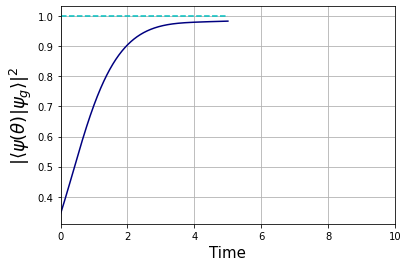

In [28]:
n = 1
colors = plt.cm.jet(np.linspace(0,1,n))

for kkk in range(1):
    plt.plot(time_domain,expt_value[kkk], color = colors[kkk])
plt.plot(time_domain,1.*np.ones(len(time_domain)), ls = "--", color ="c")

plt.ylabel(r"$|\langle \psi(\theta)|\psi_g\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
#plt.legend()
plt.xlim(0,10)
#plt.ylim(0.99,1)

#plt.savefig("Imaginary_time_evolution_fidelity_3qutrits_M=0.1_N=2_comparison.pdf")

No handles with labels found to put in legend.


(0.0, 10.0)

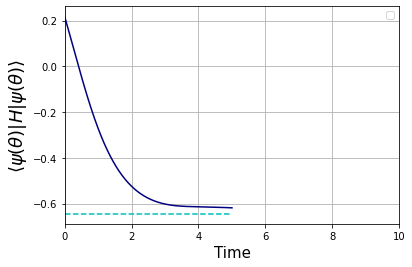

In [29]:
for kkk in range(1):
    plt.plot(time_domain,energyy[kkk], color = colors[kkk])
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="c")

plt.ylabel(r"$\langle \psi(\theta)|H|\psi(\theta)\rangle$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,10)
#plt.ylim(-0.65,-0.63)

#plt.savefig("Imaginary_time_evolution_energy_3qutrits_M=0.1_N=2_comparison.pdf")

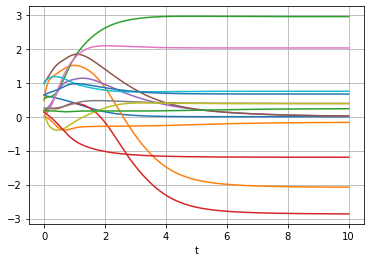

In [27]:
import matplotlib.pyplot as plt
for i in range(coeff*N):
    plt.plot(time_domain, [row[i] for row in Y])
#plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
#plt.xlim(5.9,6.1)
plt.show()

In [28]:
for i in range(coeff*N):
    print(Y[-1][i])

-0.0009822630236511927
-2.0773526708935393
2.9480469499510007
-2.864729471160893
0.018013947434421584
0.018293766962629833
2.024719767673083
0.39156328242486227
0.38360063620482215
0.7497325366621957
0.6668533985677328
-0.1685353591678328
0.23401062171479337
-1.1941919452995613


In [212]:
obs = [[1.,2]]
obs_1 = [[-1.,1]]


obs_map = [
            ["z", obs], 
            ["z", obs_1], 


]

observable = hamiltonian(obs_map,dynamic_list=[],basis=basis,**no_checks)
observable_matrix = observable.toarray()
observable_matrix_p = observable_matrix
for i in range(L+1):
    observable_matrix_p = (Proj[i]+Proj_0[i])@observable_matrix_p@(Proj[i]+Proj_0[i])
    
observable_matrix = observable_matrix_p



In [214]:
def hamiltonian_evolution(theta):
    return expm(-1j*full_ham_matrix.toarray()*theta)

def hamiltonian_evolution_1(theta):
    return expm(-1j*constrained_full_ham_matrix.toarray()*theta)

In [218]:
for i in range(coeff*N):
    print(Y[0][i])

0.37141536888406607
0.6602899660443315
0.11637371823579168
0.39901353290549235
0.9247979940631299
0.026453178512319396
0.4382807802429473
0.07025615093206115
0.3606296388374573
0.8138966259351307
0.9031720383192907
0.523454217057356
0.9272695715059814
0.9827474226150743
0.2639324508516817
0.41284186279042756
0.8757225556853009
0.523982524132141
0.9490899608210723
0.6202612047452045
0.19801202641088236
0.6716191124543176


(0.0, 10.0)

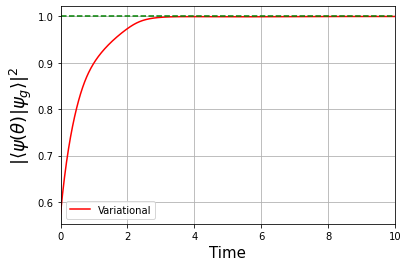

(0.0, 10.0)

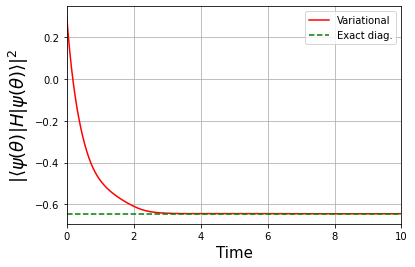

In [220]:
plt.plot(time_domain,energy, color = "red",label = "Variational")
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="g", label = "Exact diag.")

plt.ylabel(r"$|\langle \psi(\theta)|H|\psi(\theta)\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,10)
#plt.ylim(-0.65,-0.63)

#plt.savefig("Imaginary_time_evolution_energy_3qutrits_M=0.1_N=2_1.pdf")

In [221]:
print(expt_value_u[-1])

0.999481430342308


In [124]:
a = np.array([1,2,4])
ind = [1,3,5]
for i in ind:
    a = np.insert(a,i,i)
    print(a)

[1 1 2 4]
[1 1 2 3 4]
[1 1 2 3 4 5]


In [33]:
vec = np.array([1,2,3,4,5])
print(vec[-1]-vec[0])

4
